###  Librerias

In [424]:
import numpy as np
import sympy as sp
import math
import sim
import time
import cv2
import matplotlib.pyplot as plt
from sympy import *

### Inicialización
Funciones y handelers y fijación de posición de encendido

In [425]:
def connect(port):
    sim.simxFinish(-1)
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5)
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID


def gripper(val):
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
    "ROBOTIQ_85", sim.sim_scripttype_childscript,"gripper",[val],[],[],"", sim.simx_opmode_blocking)
    return res


# Controladores:
clientID = connect(19999)
retCode,grip=sim.simxGetObjectHandle(clientID,'ROBOTIQ_85',sim.simx_opmode_blocking)
retCode,joint0=sim.simxGetObjectHandle(clientID,'Joint_0',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'Joint_1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'Joint_2',sim.simx_opmode_blocking)
retCode,joint3=sim.simxGetObjectHandle(clientID,'Joint_3',sim.simx_opmode_blocking)
retCode,joint4=sim.simxGetObjectHandle(clientID,'Joint_4',sim.simx_opmode_blocking)
[res, Robotiq]=sim.simxGetObjectHandle(clientID, 'ROBOTIQ_85_attachPoint', sim.simx_opmode_blocking);
[res, tijeras]=sim.simxGetObjectHandle(clientID, 'Cuboid3', sim.simx_opmode_blocking);
[res, bisturi]=sim.simxGetObjectHandle(clientID, 'Cuboid6', sim.simx_opmode_blocking);
[res, jeringuilla]=sim.simxGetObjectHandle(clientID, 'Cuboid5', sim.simx_opmode_blocking);
[res, pinza]=sim.simxGetObjectHandle(clientID, 'Cuboid4', sim.simx_opmode_blocking);
retCode,camara=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)
retCode,cuboid0=sim.simxGetObjectHandle(clientID, 'Cuboid0', sim.simx_opmode_blocking);
retCode,cuboid=sim.simxGetObjectHandle(clientID,'Cuboid',sim.simx_opmode_blocking)

#Posicion encendido
retCode = sim.simxSetJointTargetPosition(clientID, joint4, 0, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint1, 0, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint0, 0, sim.simx_opmode_oneshot)

conectado a 19999


In [426]:
def init_pos():
    gripper(0)
    retCode = sim.simxSetJointTargetPosition(clientID, joint4, -np.pi/8, sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 3*np.pi/4, sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, np.pi/8, sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, np.pi/8, sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint0, -np.pi/8, sim.simx_opmode_oneshot)

In [427]:
def inverse_kinematics(x, y, z, cabGrados, Axis5):
    y -= 0.225
    cabRAD=cabGrados*np.pi/180
    Axis1=math.atan2(y, x)
    M=math.sqrt(pow(x,2)+pow(y,2))
    xprima=M
    yprima=z

    Afx=math.cos(cabRAD)*m
    B=xprima-Afx
    Afy=math.sin(cabRAD)*m
    A=yprima+Afy-H;
    Hip=math.sqrt(pow(A,2)+pow(B,2))
    alfa=math.atan2(A,B)
    beta=math.acos((pow(b,2)-pow(ab,2)+pow(Hip,2))/(2*b*Hip))
    Axis2=alfa+beta
    gamma=math.acos((pow(b,2)+pow(ab,2)-pow(Hip,2))/(2*b*ab))
    Axis3=gamma
    Axis4=2*np.pi-cabRAD-Axis2-Axis3

    j0=Axis1*180/np.pi #joint0
    j1=90-Axis2*180/np.pi #joint1
    j2=180-Axis3*180/np.pi #joint2
    j3=180-Axis4*180/np.pi #joint3
    j4=Axis5 + j0#joint5  Se ha dado en grados inicialmente

    return j0, j1, j2, j3, j4

In [428]:
def close_grip(element):
    gripper(1)
    time.sleep(0.1)
    returncode=sim.simxSetObjectParent(clientID, element,Robotiq, True, sim.simx_opmode_blocking);

In [429]:
def open_grip(element):
    returncode=sim.simxSetObjectParent(clientID, element,-1, False, sim.simx_opmode_blocking);
    gripper(0)

In [430]:
def finish_pos():
    retCode = sim.simxSetJointTargetPosition(clientID, joint0, -np.pi, sim.simx_opmode_oneshot)
    time.sleep(0.4)
    retCode = sim.simxSetJointTargetPosition(clientID, joint4, 0, sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, np.pi/2, sim.simx_opmode_oneshot)


In [431]:
#Medidas
l1 = 0.955
l2 = 0.3
l3 = 0.3
l4 = 0.26
dTotal = 0.0757
m = l4
H = l1
b = l2
ab = l3

### Buscar tijeras

In [432]:
init_pos()

In [433]:
j0, j1, j2, j3, j4 = inverse_kinematics(0.4, 0.225, 0.78, 90, 0)

retCode = sim.simxSetJointTargetPosition(clientID, joint4, j4*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, j3*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, j2*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint1, j1*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint0, j0*np.pi/180, sim.simx_opmode_oneshot)

In [434]:
j0, j1, j2, j3, j4 = inverse_kinematics(0.4, 0.225, 0.705, 90, 0)

retCode = sim.simxSetJointTargetPosition(clientID, joint4, j4*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, j3*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, j2*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint1, j1*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint0, j0*np.pi/180, sim.simx_opmode_oneshot)

In [435]:
close_grip(tijeras)

In [436]:
j0, j1, j2, j3, j4 = inverse_kinematics(0.4, 0.225, 0.8, 90, 0)

retCode = sim.simxSetJointTargetPosition(clientID, joint4, j4*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, j3*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, j2*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint1, j1*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint0, j0*np.pi/180, sim.simx_opmode_oneshot)

In [437]:
finish_pos()

In [438]:
open_grip(tijeras)

In [439]:
init_pos()

### Buscar jeringuilla

In [440]:
j0, j1, j2, j3, j4 = inverse_kinematics(0.425, -0.042, 0.78, 90, 0)

retCode = sim.simxSetJointTargetPosition(clientID, joint4, j4*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, j3*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, j2*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint1, j1*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint0, j0*np.pi/180, sim.simx_opmode_oneshot)

In [441]:
j0, j1, j2, j3, j4 = inverse_kinematics(0.425, -0.042, 0.705, 90, 0)

retCode = sim.simxSetJointTargetPosition(clientID, joint4, j4*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, j3*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, j2*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint1, j1*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint0, j0*np.pi/180, sim.simx_opmode_oneshot)

In [442]:
close_grip(jeringuilla)

In [443]:
j0, j1, j2, j3, j4 = inverse_kinematics(0.425, -0.042, 0.8, 90, 0)

retCode = sim.simxSetJointTargetPosition(clientID, joint4, j4*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, j3*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, j2*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint1, j1*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint0, j0*np.pi/180, sim.simx_opmode_oneshot)

In [444]:
finish_pos()

In [445]:
open_grip(jeringuilla)

### Posición camara -> Posición real

In [448]:
init_pos()

  X      Y     AREA   en la imagen 
495.68 462.55
[0.6310001015663147, 0.3619999289512634, 0.7099999785423279]
44.125 22.358
[0.054000020027160645, -0.2009999305009842, 0.7099999785423279]


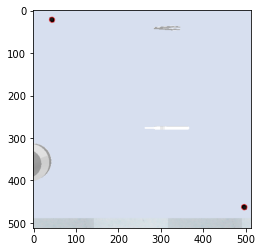

In [449]:
retCode, resolution, image=sim.simxGetVisionSensorImage(clientID,camara,0,sim.simx_opmode_oneshot_wait)
img=np.array(image,dtype=np.uint8)
img.resize([resolution[1],resolution[0],3])
detector=cv2.SimpleBlobDetector_create()
keypoints=detector.detect(img)
imagen_with_keypoints=cv2.drawKeypoints(img,keypoints,np.array([]),(0,0,255),cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(imagen_with_keypoints,cv2.COLOR_BGR2RGB))
print ("  X      Y     AREA   en la imagen ")
px1 = N(keypoints[0].pt[0],5)
py1 = N(keypoints[0].pt[1],5)
px2 = N(keypoints[1].pt[0],5)
py2 = N(keypoints[1].pt[1],5)
returnCode,pos1=sim.simxGetObjectPosition(clientID, cuboid0, -1, sim.simx_opmode_blocking)
returnCode,pos2=sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)
print(px1, py1)
print(pos1)
print(px2, py2)
print(pos2)


In [450]:
def transform_xy(x, y):
    x_return = (((x-min(px2,px1))/abs(px2-px1)))*(abs(pos1[0]-pos2[0]))+min(pos1[0],pos2[0])
    y_return = (((y-min(py2,py1))/abs(py2-py1)))*(abs(pos1[1]-pos2[1]))+min(pos1[1],pos2[1])
    return x_return, y_return

In [451]:
#Tiene que ir aproximadamente al bisturi
x, y =transform_xy(300, 280)
print(x,y)
j0, j1, j2, j3, j4 = inverse_kinematics(x, y, 0.8, 90, 0)

retCode = sim.simxSetJointTargetPosition(clientID, joint4, j4*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, j3*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, j2*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint1, j1*np.pi/180, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint0, j0*np.pi/180, sim.simx_opmode_oneshot)

0.380956241081662 0.128524138084742
